In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

In [ ]:
df.shape

(13958, 20)

In [ ]:

# import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
# df = pd.read_csv(url)
def wrangle(filepath):
  df = pd.read_csv(filepath,
              parse_dates = ['game_date'],
              index_col = 'game_date'
              )

  df['home_game'] = df['htm'] == 'GSW'
  df['home_game'] = df['home_game'].astype(int)
  df['seconds_remaining_in_q'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
  quarters_left = 4 - df['period']
  df['seconds_remaining_in_game'] = ((quarters_left * 12) * 60) + df['seconds_remaining_in_q']
  df['made_prev'] = df['shot_made_flag'].shift(1)
  df['made_prev'].fillna(0, inplace = True)

  df.drop(columns = ['player_name'],inplace = True)
  cutoff = 80
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > cutoff]
  df.drop(columns = drop_cols, inplace = True)

  dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  return df
df = wrangle(url)

In [ ]:
type(df.index)

pandas.core.indexes.range.RangeIndex

In [ ]:
df.head(15)

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,...,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,home_game,seconds_remaining_in_q,seconds_remaining_in_game,made_prev
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,...,249,0,GSW,HOU,Regular Season,2.0,1,685,2845,0.0
2009-10-28,20900015,17,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,...,145,1,GSW,HOU,Regular Season,0.0,1,571,2731,0.0
2009-10-28,20900015,53,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,...,129,0,GSW,HOU,Regular Season,-4.0,1,362,2522,1.0
2009-10-28,20900015,141,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,...,82,0,GSW,HOU,Regular Season,-4.0,1,589,2029,0.0
2009-10-28,20900015,249,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,...,148,0,GSW,HOU,Regular Season,0.0,1,139,1579,0.0
2009-10-28,20900015,277,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,...,15,0,GSW,HOU,Regular Season,4.0,1,34,1474,0.0
2009-10-28,20900015,413,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,...,149,1,GSW,HOU,Regular Season,-9.0,1,626,626,0.0
2009-10-28,20900015,453,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,...,123,1,GSW,HOU,Regular Season,-6.0,1,391,391,1.0
2009-10-28,20900015,487,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,...,162,1,GSW,HOU,Regular Season,-9.0,1,145,145,1.0


In [ ]:
X = df.drop(columns = 'shot_made_flag')
y = df['shot_made_flag']

In [ ]:

val_cutoff = '2017-09-01'
test_cutoff = '2018-09-01'

test_mask = X.index > test_cutoff
val_mask = (X.index > val_cutoff) & (X.index <= test_cutoff)

X_test = X[test_mask]
y_test = y[test_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_train = X[~(test_mask | val_mask)]
y_train = y[~(test_mask | val_mask)]

X_train.shape,y_train.shape

((11081, 21), (11081,))

In [ ]:

baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


In [ ]:

model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs = -1,
        random_state = 42
    )
)
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot                     6
Reverse Layup Shot                     7
Running Jump Shot                      8
Floating Jump...
                                          'mapping': HOU     1
GSW     2
MEM     3
LAC     4
MIN     5
POR     6
LAL     7
IND     8
ORL     9
SAS    10
WAS    11
PHX    12
BOS    13
SAC    14
CLE    15
MIA    16
MIL    17
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [ ]:

train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5916095890410958


In [ ]:

clf_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier()
)
param_grid = {
    'randomforestclassifier__max_depth':range(5,75,5),
    'randomforestclassifier__n_estimators':range(10,250,10),
    'randomforestclassifier__min_samples_split':range(2,4,1),
    'randomforestclassifier__min_samples_leaf':range(1,3,1),
    'randomforestclassifier__max_samples':range(25,100,5)
}
model_tune = RandomizedSearchCV(
    clf_rf,
    param_distributions= param_grid,
    n_jobs = -1,
    verbose = 1,
    n_iter = 3,
    cv = None
)
model_tune.fit(X_train,y_train)


test_acc = model_tune.best_score_
print('Testing Accuracy Score:', test_acc)
print(model_tune.best_params_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Testing Accuracy Score: 0.6286425536834667
{'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_samples': 80, 'randomforestclassifier__max_depth': 70}


In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs = -1,
        random_state = 42,
        n_estimators= 150,
        min_samples_leaf= 2,
        min_samples_split= 3,
        max_depth=70,
        max_samples = 300
    )
)
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot                     6
Reverse Layup Shot                     7
Running Jump Shot                      8
Floating Jump...
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=70, max_samples=300,
                                        min_samples_leaf=2, min_samples_split=3,
                                        n_estimators=150, n_jobs=-1,
                                        random_state=42))])

In [ ]:
model.score(X_train,y_train),model.score(X_val,y_val)

(0.6730439491020666, 0.6061643835616438)

In [ ]:

instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


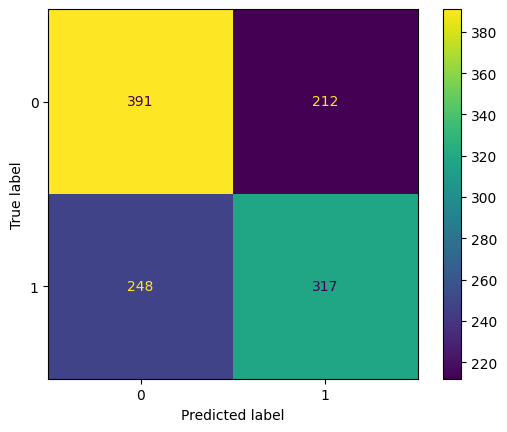

In [ ]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator

plot_confusion_matrix(
    model,
    X_val,
    y_val
);